## 1. Import Data

This step brings in important tools that help us work with data, create machine learning models, and make charts.

In [1]:
import pandas as pd
import joblib
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from google.colab import drive


## 2. Load Data

Here, we load data from an Excel file, show the first 10 rows to check, and handle any issues if the file doesn’t load properly.


## 3. PreProcess Data

We clean the data by converting everything into numbers, replacing missing values with zeros, and ensuring it's ready for the model.

In [ ]:
drive.mount('/content/drive')

def load_data(file_path):
    """Load data from an Excel file and display the first 10 rows."""
    try:
        data = pd.read_excel(file_path, engine='openpyxl')
        print("Data loaded successfully.")
        print("First 10 rows of the data:")
        display(data.head(10))
        return data
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

file_path = '/content/drive/MyDrive/KSU/RCapstone/feature-prediction/data/input_data.xlsx'  # Update this to the correct path
data = load_data(file_path)

Mounted at /content/drive
Data loaded successfully.
First 10 rows of the data:


,Name,Timestamp,Status,Description,Vibration Frequency,Vibration Amplitude,Bearing Temperature,Motor Temperature,Belt Load,Torque,Noise Levels,Current and Voltage,Hydraulic Pressure,Belt Thickness,Roller Condition
0,Conveyor Belt 1,2023-08-15 00:00:00,Running,NaN,1505.34,0.05,77.63,97.64,1.39,287.25,61.65,15.95,381.44,1.55,90
1,Conveyor Belt 1,2023-08-15 00:15:00,Running,NaN,1498.04,0.05,77.71,97.71,1.04,307.24,62.95,14.2,380.3,1.5495,89.854
2,Conveyor Belt 1,2023-08-15 00:30:00,Running,NaN,1499.6,0.05,77.91,97.91,1.27,287.26,64.27,15.35,375.42,1.54925,89.781
3,Conveyor Belt 1,2023-08-15 00:45:00,Running,NaN,1502.55,0.06,78.11,98.11,1.18,301.01,NaN,14.9,384.68,1.549,89.708
4,Conveyor Belt 1,2023-08-15 01:00:00,Running,NaN,1507.47,0.04,78.31,98.31,1.35,308.36,58.99,15.75,382.99,1.54875,89.635
5,Conveyor Belt 1,2023-08-15 01:15:00,Running,NaN,1509.68,0.06,78.51,98.51,1.07,284.28,56.52,14.35,377.93,1.5485,89.562
6,Conveyor Belt 1,2023-08-15 01:30:00,Running,NaN,1505.37,0.06,78.71,98.71,1.28,302.69,64.92,NaN,384.8,1.54825,89.489
7,Conveyor Belt 1,2023-08-15 01:45:00,Running,NaN,1498.36,0.04,78.9,98.9,1.34,290.26,64.27,15.7,381.02,1.548,89.416
8,Conveyor Belt 1,2023-08-15 02:00:00,Running,NaN,1498.43,0.06,79.1,ERROR,1.38,318.52,60.4,15.9,380.82,1.54775,89.343
9,Conveyor Belt 1,2023-08-15 02:15:00,Running,NaN,1504.75,0.04,79.3,99.3,1.27,299.34,63.42,15.35,382.48,1.5475,89.27


In [ ]:
def preprocess_data(data):
    """Preprocess the data: handle numeric columns and fill NaN values."""
    data = data.apply(pd.to_numeric, errors='coerce')
    data.fillna(0, inplace=True)
    print("Data has been preprocessed.")
    return data

processed_data = preprocess_data(data)

Data has been preprocessed.


## 4. Define Model

This step creates a simple neural network with input, hidden, and output layers that will help the model learn and make predictions.

In [ ]:
def build_model(input_shape):
    """Build a simple neural network model."""
    inputs = Input(shape=(input_shape,))
    x = Dense(128, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)  # Assuming a regression task, modify if needed
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## 5. Train Model
The data is scaled and split into training and test sets. We train the neural network for each target column, saving models and tools for future use, and stopping early if the model starts overfitting.


In [ ]:
def train_model(data, target_column):
    """Train a neural network model on the provided data for a specific target column."""
    X = data.drop(columns=target_column)  # Drop the target column
    y = data[target_column]  # Target variable

    feature_names = X.columns.tolist()

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)  # Scale all features

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = build_model(X_train.shape[1])  # Input shape for the model

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

    model.save(f'models/{target_column}_model.h5')
    joblib.dump(scaler, f'models/{target_column}_scaler.pkl')  # Save the scaler
    joblib.dump(feature_names, f'models/{target_column}_feature_names.pkl')  # Save the feature names

    print(f"Model for {target_column} trained and saved successfully.")
    return model, scaler, history, feature_names




target_columns = [
    'Vibration Frequency',
    'Vibration Amplitude',
    'Bearing Temperature',
    'Motor Temperature',
    'Belt Load',
    'Torque',
    'Noise Levels',
    'Current and Voltage',
    'Hydraulic Pressure',
    'Belt Thickness',
    'Roller Condition'
]


models = {}
scalers = {}
histories = {}
feature_names_dict = {}

for target in target_columns:
    print(f"Training model for {target}...")

    model, scaler, history, feature_names = train_model(processed_data, target)

    models[target] = model
    scalers[target] = scaler
    histories[target] = history
    feature_names_dict[target] = feature_names

Training model for Vibration Frequency...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2225604.0000 - val_loss: 2195583.2500
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2189927.2500 - val_loss: 2060316.1250
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2002612.0000 - val_loss: 1681966.0000
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1540463.8750 - val_loss: 1023694.4375
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 844704.7500 - val_loss: 355719.5938
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 246323.6094 - val_loss: 59932.0117
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32792.1992 - val_loss: 32279.2969
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19155.8105 - val_loss: 32428.6289
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21250.7051 - val_loss: 32399.7871
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20049.8867 - val_loss: 32361.0215
Epoch 11

Model for Vibration Frequency trained and saved successfully.
Training model for Vibration Amplitude...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0572 - val_loss: 9.3945e-04
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9434e-04 - val_loss: 2.6935e-04
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7334e-04 - val_loss: 1.6621e-04
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3145e-04 - val_loss: 1.3585e-04
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2098e-04 - val_loss: 1.1573e-04
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0005e-04 - val_loss: 1.0433e-04
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0296e-04 - val_loss: 1.1427e-04
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.5844e-05 - val_loss: 9.7507e-05
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6443e-05 - val_loss: 9.5014e-05
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5

Model for Vibration Amplitude trained and saved successfully.
Training model for Bearing Temperature...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4750.4580 - val_loss: 3974.6638
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3237.0974 - val_loss: 714.3547
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 328.8040 - val_loss: 83.9445
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131.7696 - val_loss: 81.1885
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79.6339 - val_loss: 82.0018
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108.1386 - val_loss: 81.0449
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95.4708 - val_loss: 81.0983
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119.3679 - val_loss: 81.1040
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87.7297 - val_loss: 82.4500
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92.9719 - val_loss: 80.6914
Epoch 11/100
4

Model for Bearing Temperature trained and saved successfully.
Training model for Motor Temperature...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 7870.4526 - val_loss: 6768.4365
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5742.6743 - val_loss: 2076.7073
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1116.0486 - val_loss: 184.9034
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 176.6288 - val_loss: 165.1893
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121.7363 - val_loss: 165.0535
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110.1023 - val_loss: 164.8986
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107.5821 - val_loss: 165.1729
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167.2757 - val_loss: 164.8581
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122.1163 - val_loss: 164.5362
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160.2432 - val_loss: 164.2543
Ep

Model for Motor Temperature trained and saved successfully.
Training model for Belt Load...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2677 - val_loss: 0.0164
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211 - val_loss: 0.0158
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0226 - val_loss: 0.0150
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 0.0140
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.0145
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0171 - val_loss: 0.0145
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173 - val_loss: 0.0144
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - val_loss: 0.0126
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0122
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0118
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

Model for Belt Load trained and saved successfully.
Training model for Torque...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 86887.1406 - val_loss: 82459.1797
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77894.7266 - val_loss: 56945.2383
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45211.5938 - val_loss: 11291.4844
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6443.2944 - val_loss: 845.1292
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1385.3597 - val_loss: 832.4059
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1115.1124 - val_loss: 828.6177
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2193.5112 - val_loss: 820.6318
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1094.7090 - val_loss: 830.1032
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1738.6484 - val_loss: 818.3720
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1935.6490 - val_loss: 821.4381
Epoch 11/

Model for Torque trained and saved successfully.
Training model for Noise Levels...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3360.2129 - val_loss: 2506.1895
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1940.9677 - val_loss: 192.3872
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99.5842 - val_loss: 47.9547
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.2861 - val_loss: 47.4925
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29.4289 - val_loss: 47.2583
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38.9810 - val_loss: 47.5082
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.0405 - val_loss: 47.4988
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.5556 - val_loss: 47.2849
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53.4730 - val_loss: 46.9838
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33.4723 - val_loss: 47.0464
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━

Model for Noise Levels trained and saved successfully.
Training model for Current and Voltage...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 172.0532 - val_loss: 21.9796
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6184 - val_loss: 1.9979
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3520 - val_loss: 1.8099
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0963 - val_loss: 1.7997
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5076 - val_loss: 1.7888
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8853 - val_loss: 1.7718
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9464 - val_loss: 1.7448
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9668 - val_loss: 1.7595
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1103 - val_loss: 1.7427
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5524 - val_loss: 1.6787
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/s

Model for Current and Voltage trained and saved successfully.
Training model for Hydraulic Pressure...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 142306.8438 - val_loss: 136412.2500
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 135058.9844 - val_loss: 118246.1406
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110130.2969 - val_loss: 69986.2734
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55902.5078 - val_loss: 16396.4316
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9652.7920 - val_loss: 4509.2065
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2991.3328 - val_loss: 4576.4971
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2590.6013 - val_loss: 4553.0830
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1870.9413 - val_loss: 4539.6553
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1788.6270 - val_loss: 4543.6187
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2004.

Model for Hydraulic Pressure trained and saved successfully.
Training model for Belt Thickness...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7101 - val_loss: 0.0366
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - val_loss: 0.0234
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0384 - val_loss: 0.0220
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383 - val_loss: 0.0211
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - val_loss: 0.0213
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277 - val_loss: 0.0216
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 - val_loss: 0.0208
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0421 - val_loss: 0.0206
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0247 - val_loss: 0.0205
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.0205
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Model for Belt Thickness trained and saved successfully.
Training model for Roller Condition...
Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6636.2739 - val_loss: 5394.3667
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4302.8447 - val_loss: 884.3049
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 465.6956 - val_loss: 183.1012
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 230.3009 - val_loss: 181.4397
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 224.5023 - val_loss: 181.9452
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 182.0258 - val_loss: 181.6845
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 190.2365 - val_loss: 181.2899
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 191.0479 - val_loss: 182.7772
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 237.8543 - val_loss: 180.9396
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 215.9263 - val_loss: 183.2430
Epoch 11/1

Model for Roller Condition trained and saved successfully.


# 6. Display Training History

This step shows the loss (errors) during training and validation to help us understand how well the model is learning.

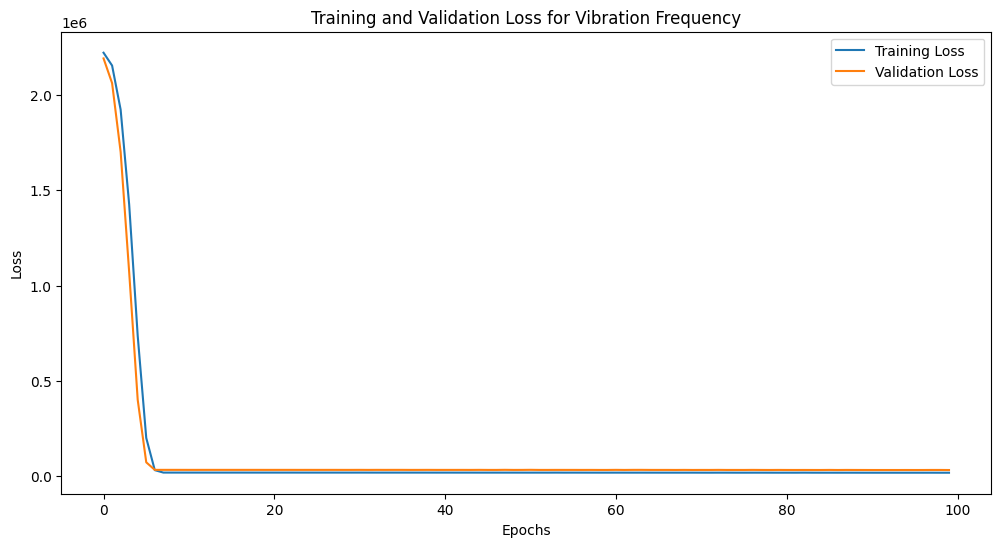

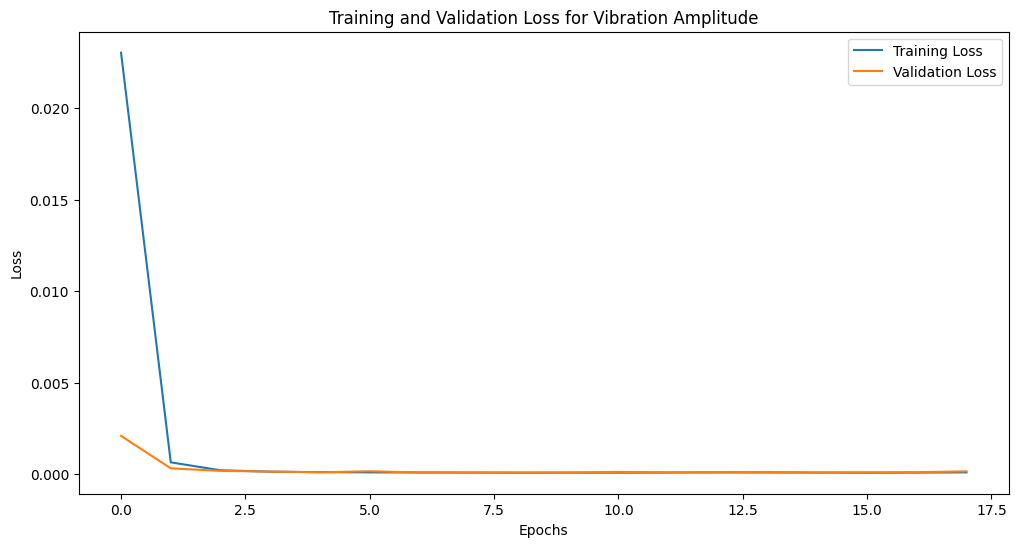

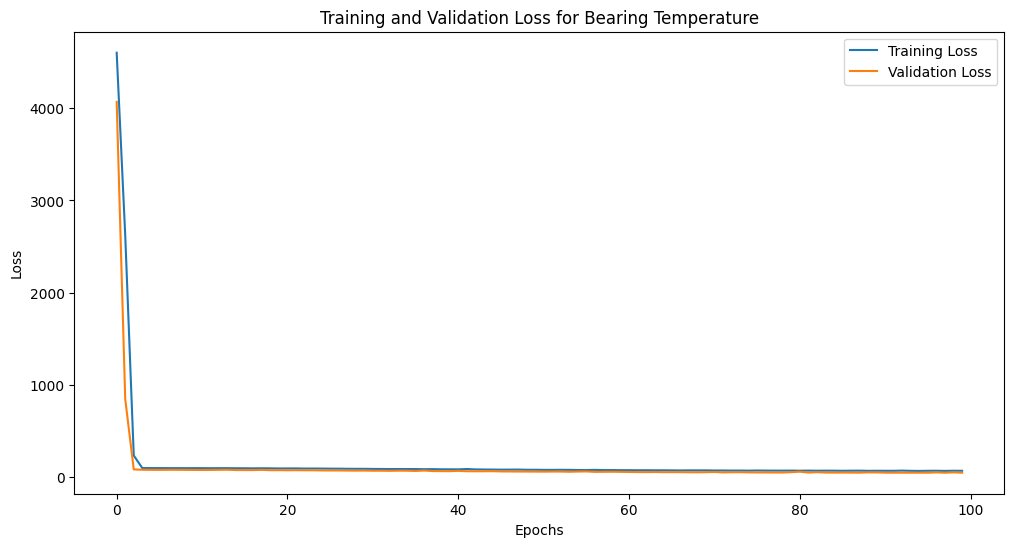

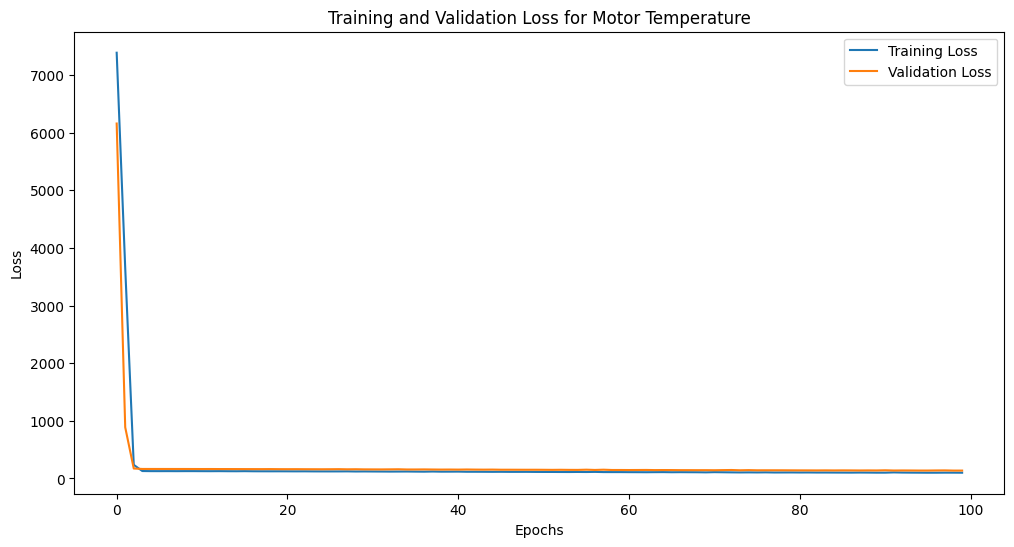

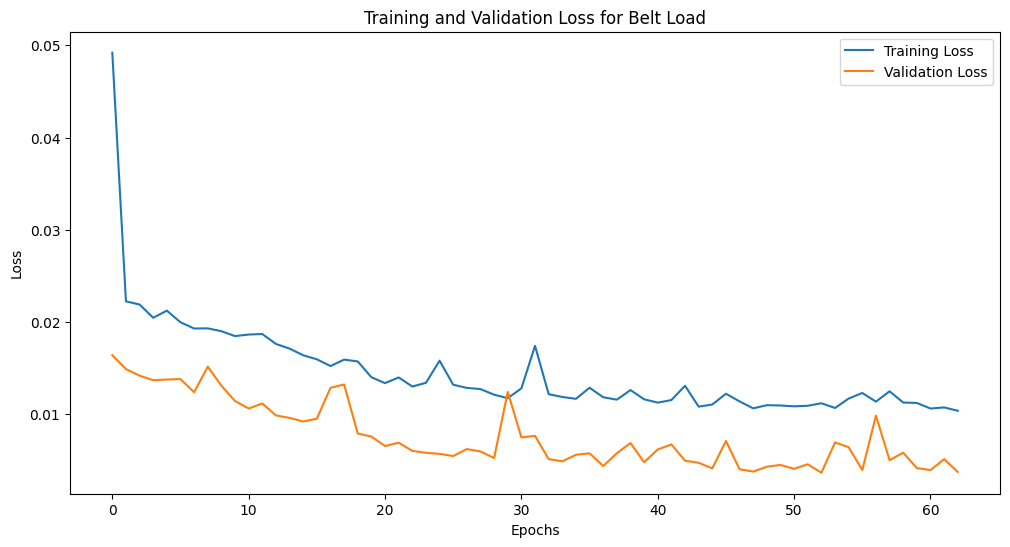

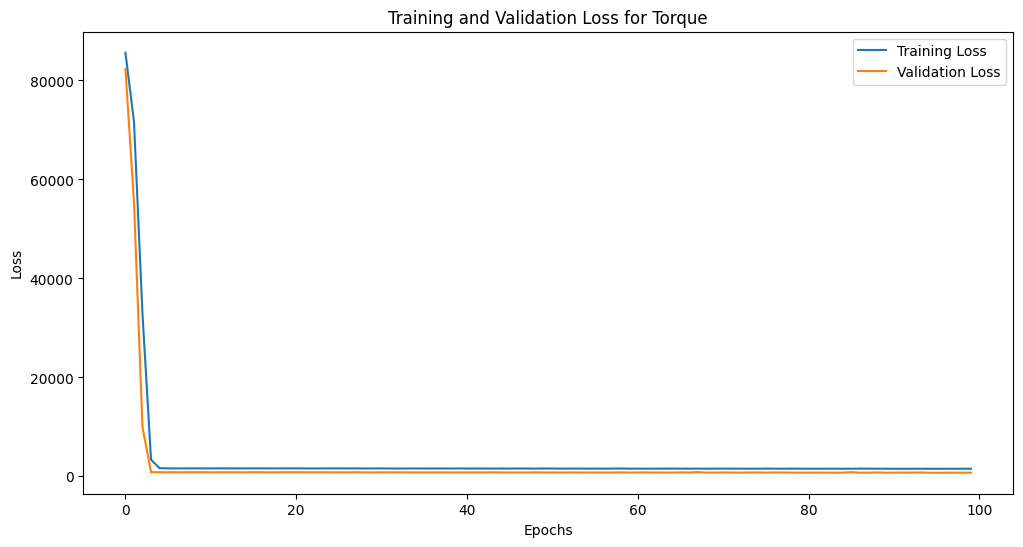

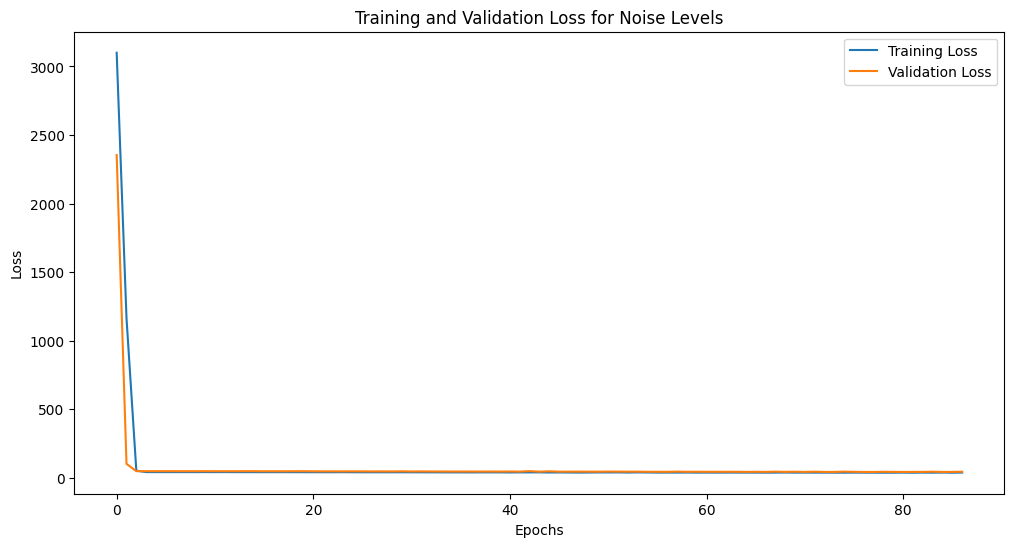

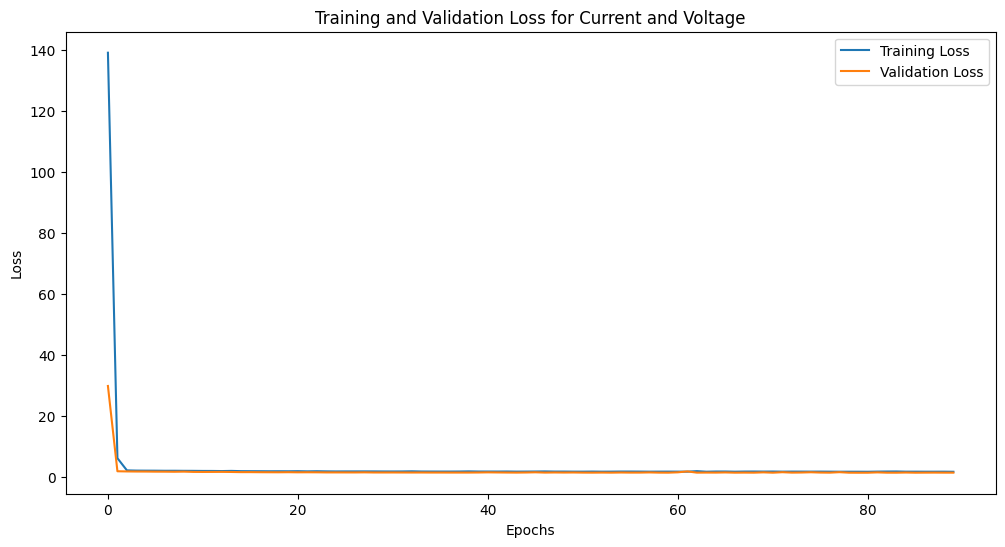

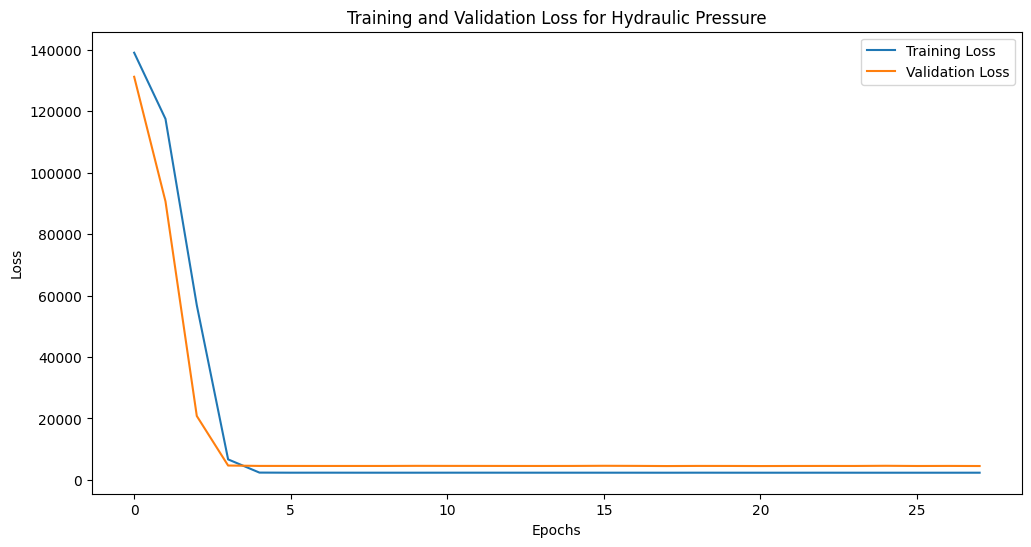

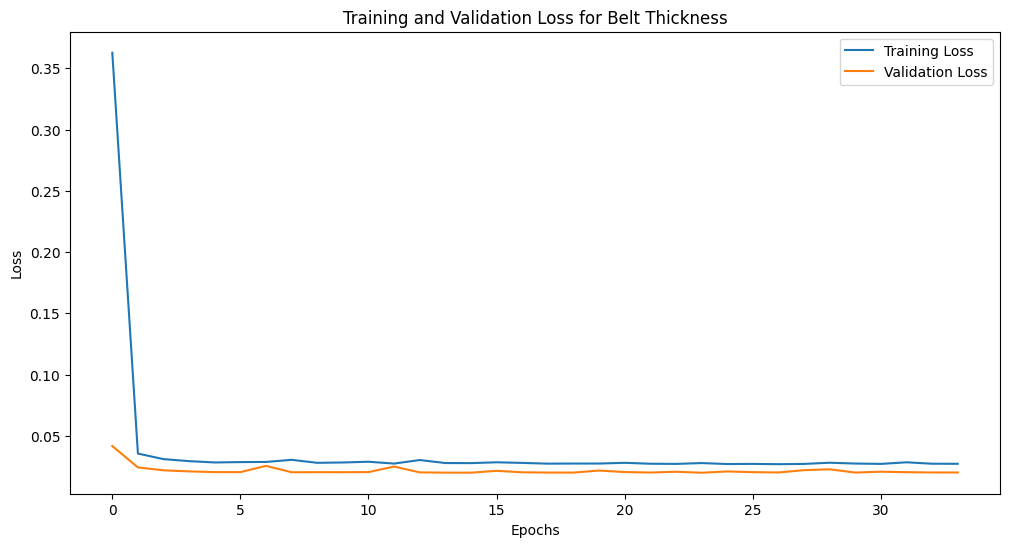

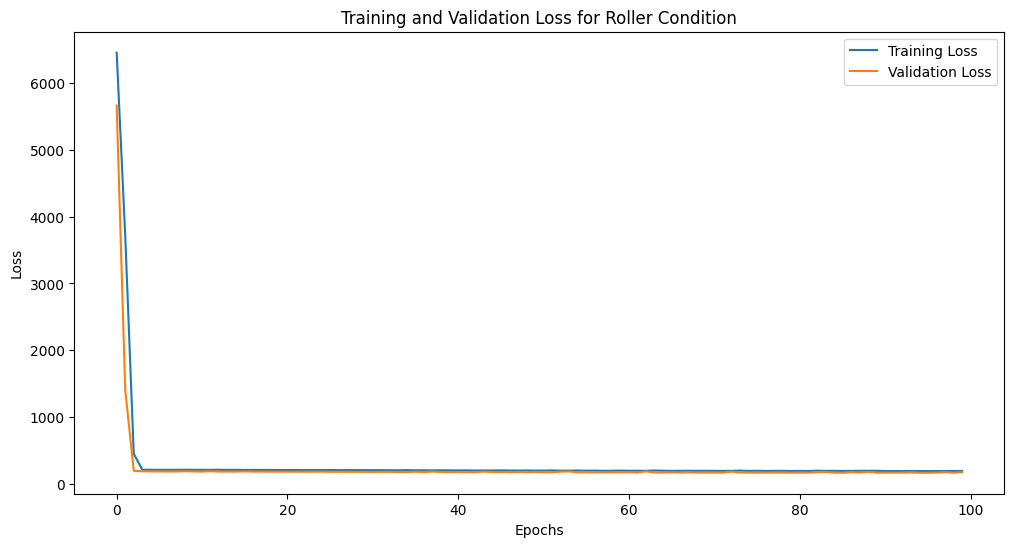

In [ ]:
def plot_history(history, target):
    """Plot the training and validation loss over epochs for each model."""
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {target}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

for target, history in histories.items():
    plot_history(history, target)


# 7.Evaluate Model

The model predicts the last 10 rows of training data, compares predictions to actual values, and uses colors to highlight how close the predictions are to the real values.

In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display
import joblib

def color_rows(row, target_columns, tolerance=0.01):
    """Color-code predicted rows based on the prediction accuracy."""
    colors = [''] * len(row)
    if row['Type'] == 'Predicted':
        for col in target_columns:
            original_col = f'Original {col}'
            if original_col in row and col in row:
                original = row[original_col]
                predicted = row[col]
                if isinstance(predicted, list):
                    predicted = predicted[0]
                difference = abs(predicted - original)


                if difference <= tolerance:
                    colors[row.index.get_loc(col)] = 'background-color: green'
                elif tolerance < difference <= 0.05:
                    colors[row.index.get_loc(col)] = 'background-color: yellow'
                else:  # Significant difference
                    colors[row.index.get_loc(col)] = 'background-color: red'
    return colors

def predict_last_rows(models, data, scalers, target_columns):
    """Predict the last 10 rows of the training data and display original vs. predicted values."""

    last_n_rows = data.tail(100)

    results = []

    for i in range(len(last_n_rows)):
        original_row = {'Type': 'Original'}
        predicted_row = {'Type': 'Predicted'}

        for target in target_columns:
            feature_names = joblib.load(f'models/{target}_feature_names.pkl')

            X_last = last_n_rows.iloc[[i]][feature_names]

            X_last_scaled = scalers[target].transform(X_last)

            predictions = models[target].predict(X_last_scaled)

            original_row[target] = last_n_rows.iloc[i][target]
            predicted_row[target] = predictions[0].item() if isinstance(predictions[0], (list, np.ndarray)) else predictions[0]  # Extract scalar value from prediction array

        results.append(original_row)
        results.append(predicted_row)

    results_df = pd.DataFrame(results)

    columns_to_display = ['Type'] + target_columns

    styled_df = results_df[columns_to_display].style.apply(lambda row: color_rows(row, target_columns), axis=1)

    display(styled_df)

target_columns = [
    'Vibration Frequency',
    'Vibration Amplitude',
    'Bearing Temperature',
    'Motor Temperature',
    'Belt Load',
    'Torque',
    'Noise Levels',
    'Current and Voltage',
    'Hydraulic Pressure',
    'Belt Thickness',
    'Roller Condition'
]

predict_last_rows(models, processed_data, scalers, target_columns)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

,Type,Vibration Frequency,Vibration Amplitude,Bearing Temperature,Motor Temperature,Belt Load,Torque,Noise Levels,Current and Voltage,Hydraulic Pressure,Belt Thickness,Roller Condition
0,Original,1507.010000,0.060000,76.920000,96.920000,1.290000,283.870000,61.920000,15.450000,383.860000,1.637000,94.598000
1,Predicted,1555.982300,0.053294,73.108162,94.358780,1.272508,308.380157,60.044361,15.438482,393.787018,1.623459,82.684273
2,Original,1507.350000,0.050000,77.110000,97.110000,1.110000,298.010000,55.620000,14.550000,380.930000,1.636750,94.525000
3,Predicted,1505.089966,0.050442,73.372421,93.769028,1.098428,299.611115,59.213577,14.567520,378.881226,1.601204,80.816193
4,Original,1504.170000,0.040000,77.310000,97.310000,1.170000,310.250000,60.090000,14.850000,378.920000,1.636500,94.452000
5,Predicted,1517.405151,0.049739,73.979790,93.735283,1.167147,303.273804,60.162567,14.909553,379.322327,1.622500,82.488983
6,Original,1506.740000,0.040000,77.510000,97.510000,1.050000,293.900000,64.970000,14.250000,379.130000,1.636250,0.000000
7,Predicted,1384.257568,0.050476,78.949989,97.200874,1.033749,285.535095,58.563557,14.671509,341.190735,1.613228,81.633759
8,Original,1505.340000,0.050000,77.630000,97.640000,1.390000,287.250000,61.650000,15.950000,381.440000,1.636000,94.306000
9,Predicted,1557.034058,0.052927,73.795853,94.269669,1.371690,309.487305,61.161976,15.809451,392.411194,1.608389,83.408417


## 8. Predict Next 10 rows

Based on the last row of data, the model predicts the next 10 rows for each column and displays the predicted results.

In [ ]:
def predict_next_rows_from_training(models, data, scalers, target_columns, num_predictions=10):
    """Predict the next `num_predictions` rows based on the trained data."""

    last_row = data.tail(1).copy()  # Use copy to avoid the slice warning

    predicted_results = []

    for i in range(num_predictions):
        predicted_row = {}

        for target in target_columns:
            try:
                feature_names = joblib.load(f'models/{target}_feature_names.pkl')

                X_last = last_row[feature_names]

                X_last_scaled = scalers[target].transform(X_last)

                prediction = models[target].predict(X_last_scaled)

                predicted_value = prediction[0].item() if isinstance(prediction[0], (list, np.ndarray)) else prediction[0]

                predicted_row[target] = predicted_value

                last_row.loc[:, target] = predicted_row[target]

            except Exception as e:
                print(f"Error predicting {target} for row {i}: {e}")
                predicted_row[target] = None

        predicted_results.append(predicted_row)

    predicted_df = pd.DataFrame(predicted_results)

    print(f"Predicted next {num_predictions} rows based on the trained data:")
    display(predicted_df)

    return predicted_df

target_columns = [
    'Vibration Frequency',
    'Vibration Amplitude',
    'Bearing Temperature',
    'Motor Temperature',
    'Belt Load',
    'Torque',
    'Noise Levels',
    'Current and Voltage',
    'Hydraulic Pressure',
    'Belt Thickness',
    'Roller Condition'
]

predicted_df = predict_next_rows_from_training(models, processed_data, scalers, target_columns, num_predictions=10)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

,Vibration Frequency,Vibration Amplitude,Bearing Temperature,Motor Temperature,Belt Load,Torque,Noise Levels,Current and Voltage,Hydraulic Pressure,Belt Thickness,Roller Condition
0,1497.901367,0.049576,74.220955,92.242043,1.080857,299.238190,58.293270,14.408117,372.884064,1.592865,80.838875
1,1471.261230,0.050431,70.809624,89.451126,1.116406,291.956024,57.610527,14.406101,366.785522,1.562209,80.431847
2,1454.871338,0.050330,68.683807,87.495949,1.134752,289.366425,57.233265,14.417670,363.848724,1.550254,80.358597
3,1445.650024,0.050210,67.213181,86.242722,1.146276,288.052368,57.073399,14.436042,362.252808,1.544256,80.388504
4,1440.368408,0.050139,66.271126,85.460716,1.155012,287.388580,57.005207,14.457704,361.423218,1.541096,80.447800
5,1437.612061,0.050115,65.683456,84.981560,1.161928,287.084167,56.988464,14.480214,361.052673,1.539597,80.517815
6,1436.419922,0.050115,65.322899,84.694031,1.167524,286.991730,57.001213,14.502153,360.953094,1.539095,80.590729
7,1436.155518,0.050130,65.106010,84.526947,1.172127,287.022003,57.029793,14.522772,361.010468,1.539173,80.661850
8,1436.423828,0.050153,64.979485,84.434944,1.175961,287.119507,57.065941,14.541711,361.153320,1.539573,80.728706
9,1436.978882,0.050179,64.909332,84.389183,1.179191,287.250183,57.104679,14.558842,361.337250,1.540134,80.790146
